# Data Analysis

# APIs and data acquisition

In this notebook we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * ~~[Twitter](https://dev.twitter.com/rest/public)~~ (still documented, but now expensive)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
Working with an API is a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs on the web: REST (REpresentational State Transfer). REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for [cat facts](https://alexwohlbruck.github.io/cat-facts/) this would be
```
https://cat-fact.herokuapp.com
```

A query would look like this: 

```
https://cat-fact.herokuapp.com/facts/random?amount=3
```


REST APIs can return data in different forms. The most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import requests 
import pandas as pd
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response with the message "200". What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [404]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
print(response.content)

b'{"timestamp": 1709284163, "iss_position": {"longitude": "-23.8833", "latitude": "36.9217"}, "message": "success"}'


We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"timestamp": 1709284163, "iss_position": {"longitude": "-23.8833", "latitude": "36.9217"}, "message": "success"}


Let's take a look at the JSON with nice formatting here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1475240215
}
```

This looks a lot like a dictionary (or objects, for that matter)! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [6]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'timestamp': 1709284163, 'iss_position': {'longitude': '-23.8833', 'latitude': '36.9217'}, 'message': 'success'}


{'longitude': '-23.8833', 'latitude': '36.9217'}

Or, not surprisingly, pandas can also load a json object:

In [7]:
import pandas as pd 

df = pd.read_json(response_j)
df

,timestamp,iss_position,message
latitude,2024-03-01 09:09:23,36.9217,success
longitude,2024-03-01 09:09:23,-23.8833,success


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_flat = {}
    response_flat["latitude"] = response_d["iss_position"]["latitude"]
    response_flat["longitude"] = response_d["iss_position"]["longitude"]
    response_flat["timestamp"] = response_d["timestamp"]
    return response_flat
flatten(response_d)

{'latitude': '36.9217', 'longitude': '-23.8833', 'timestamp': 1709284163}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [9]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'latitude': '36.8809', 'longitude': '-23.8247', 'timestamp': 1709284164}
{'latitude': '36.7583', 'longitude': '-23.6493', 'timestamp': 1709284167}
{'latitude': '36.6150', 'longitude': '-23.4454', 'timestamp': 1709284171}
{'latitude': '36.4506', 'longitude': '-23.2134', 'timestamp': 1709284175}
{'latitude': '36.3064', 'longitude': '-23.0113', 'timestamp': 1709284178}
{'latitude': '36.1824', 'longitude': '-22.8387', 'timestamp': 1709284181}
{'latitude': '36.0168', 'longitude': '-22.6095', 'timestamp': 1709284185}
{'latitude': '35.8714', 'longitude': '-22.4097', 'timestamp': 1709284189}
{'latitude': '35.7256', 'longitude': '-22.2108', 'timestamp': 1709284192}
{'latitude': '35.5794', 'longitude': '-22.0125', 'timestamp': 1709284196}


10

Now we can convert this into a nice dataframe:

In [10]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)
iss_position_df

,latitude,longitude,timestamp
timestamp,,,
2024-03-01 09:09:24,36.8809,-23.8247,2024-03-01 09:09:24
2024-03-01 09:09:27,36.7583,-23.6493,2024-03-01 09:09:27
2024-03-01 09:09:31,36.6150,-23.4454,2024-03-01 09:09:31
2024-03-01 09:09:35,36.4506,-23.2134,2024-03-01 09:09:35
2024-03-01 09:09:38,36.3064,-23.0113,2024-03-01 09:09:38
2024-03-01 09:09:41,36.1824,-22.8387,2024-03-01 09:09:41
2024-03-01 09:09:45,36.0168,-22.6095,2024-03-01 09:09:45
2024-03-01 09:09:49,35.8714,-22.4097,2024-03-01 09:09:49
2024-03-01 09:09:52,35.7256,-22.2108,2024-03-01 09:09:52


Let's see how the ISS moves

<Axes: xlabel='latitude', ylabel='longitude'>

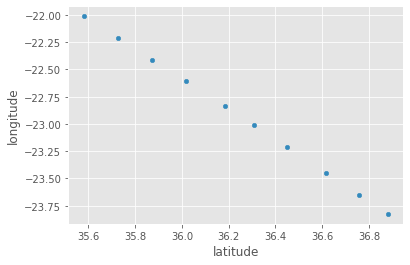

In [11]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### More queries

We can use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

In [12]:
url = "http://api.open-notify.org/astros.json"

r = requests.get(url)
data = r.json()
data

{'message': 'success',
 'people': [{'name': 'Jasmin Moghbeli', 'craft': 'ISS'},
  {'name': 'Andreas Mogensen', 'craft': 'ISS'},
  {'name': 'Satoshi Furukawa', 'craft': 'ISS'},
  {'name': 'Konstantin Borisov', 'craft': 'ISS'},
  {'name': 'Oleg Kononenko', 'craft': 'ISS'},
  {'name': 'Nikolai Chub', 'craft': 'ISS'},
  {'name': "Loral O'Hara", 'craft': 'ISS'}],
 'number': 7}

### More Queries

Let's use another public API to demonstrate queries: [PokeAPI](https://pokeapi.co/):

![PokeAPI Screenshot](pokeapiscreenshot.png)

Notice how this one boasts several endpoints (`pokemon`, `ability`, `type`, etc) for different kinds of queries.

Let's start with with the `pokemon` endpoint to get data for specific pokemon. We can look at the documentation and see that it returns a pretty large JSON object. Scanning through, I see there's a keyword `game_indices` which has members beneath it for the `game_index` and `version`>`name`. I'll print out all of those.

![PokeAPI Screenshot](pokemonendpoint.png)

In [13]:
bulbresponse = requests.get("http://pokeapi.co/api/v2/pokemon/bulbasaur")

# Check to make sure it worked
if bulbresponse.status_code == 200:
    
    # Convert to JSON and loop through to see the index and versions
    bulbj = json.loads(bulbresponse.content)
    for game in bulbj["game_indices"]:
        print(f'Index: {game["game_index"]} in {game["version"]["name"]}')
        
# If the status code is something else, check it
else:
    print(bulbresponse)

Index: 153 in red
Index: 153 in blue
Index: 153 in yellow
Index: 1 in gold
Index: 1 in silver
Index: 1 in crystal
Index: 1 in ruby
Index: 1 in sapphire
Index: 1 in emerald
Index: 1 in firered
Index: 1 in leafgreen
Index: 1 in diamond
Index: 1 in pearl
Index: 1 in platinum
Index: 1 in heartgold
Index: 1 in soulsilver
Index: 1 in black
Index: 1 in white
Index: 1 in black-2
Index: 1 in white-2


What if we want several Pokemon? This API provides us a way to index the results with the keywords `limit` and `offest`. We use the `?` to indicate we are passing parameters and the ampersand `&` to glue the parameters together.

In [14]:
response5 = requests.get("http://pokeapi.co/api/v2/location?limit=10&offset=5")

# Check to make sure it worked
if response5.status_code == 200:
    
    # Convert to JSON and loop through to see the name and URL
    j5 = json.loads(response5.content)
    for place in j5["results"]:
        print(place["name"], '\t', place["url"])
        
# If the status code is something else, check it
else:
    print(response5)

oreburgh-mine 	 https://pokeapi.co/api/v2/location/6/
valley-windworks 	 https://pokeapi.co/api/v2/location/7/
eterna-forest 	 https://pokeapi.co/api/v2/location/8/
fuego-ironworks 	 https://pokeapi.co/api/v2/location/9/
mt-coronet 	 https://pokeapi.co/api/v2/location/10/
great-marsh 	 https://pokeapi.co/api/v2/location/11/
solaceon-ruins 	 https://pokeapi.co/api/v2/location/12/
sinnoh-victory-road 	 https://pokeapi.co/api/v2/location/13/
ravaged-path 	 https://pokeapi.co/api/v2/location/14/
oreburgh-gate 	 https://pokeapi.co/api/v2/location/15/


For this API, there are end points for most indices and names, so `limit` and `offset` are really there to provide a mechanism to do pagination of the results. In other APIs, this method may be the most expedient way to provide parameters for queries.

Another thing to note is that the PokeAPI policies **require caching** so they don't have to serve up large quantities of data repeatedly to the same client. There are several libraries, [such as this one](https://github.com/PokeAPI/pokebase) that can handle this for you for this particular API. If you use an API in #datamadness (or any other project), please make sure you are following the API's policies.

Let's see one more example of using parameters from [nationalize.io](https://nationalize.io/) which purportedly predicts nationality based on last name. *We don't vouch for it--we're just using it as a free API with a parameter.* Note that it is limited to 100 requests/day without an API key.

In [15]:
response = requests.get("https://api.nationalize.io/?name=wang")

# Check to make sure it worked
if response.status_code == 200:
    
    # Print the summary of the taco
    responsej = json.loads(response.content)
    for country in responsej['country']:
        print(f'{country["country_id"]}, probability:{country["probability"]}')
        
# If the status code is something else, check it
else:
    print(response)

CN, probability:0.435
TW, probability:0.261
HK, probability:0.065
SQ, probability:0.061
NZ, probability:0.023


### Libraries, Authentications and keys

Several providers use an identifier to distinguish applications (or individuals), apply limits, or charge for services. Even those that are free may use API keys to prevent abuse or to prepare to upsell you to a more wide or permissive plan.

Note that a provider may not generate an API key immediately. It can often require some lead time. Therefore, if you plan to use a service that requires some form of authorization/authentication for your project, please note in your report whether you already have such capability.

Let's see an example of an API key as used in [OpenWeather](https://openweathermap.org/api). Note this service has a free plan, but also *several* paid plans. We're specifically using the free API described [here](https://openweathermap.org/current).

I have hidden my API_KEY in a file `credentials.py` so I can import the variable without sharing it with you :)

In [16]:
# Read my API Key into a variable
from credentials import API_KEY

# OpenWeather just has me send the API Key as the APPID parameter in my request:
response = requests.get(f'https://api.openweathermap.org/data/2.5/weather?lat=50.85&lon=5.6910&APPID={API_KEY}')
if response.status_code == 200:
    
    # Print the summary of the taco
    responsej = json.loads(response.content)
    print(responsej)
        
# If the status code is something else, check it
else:
    print(response)

{'coord': {'lon': 5.691, 'lat': 50.85}, 'weather': [{'id': 802, 'main': 'Clouds', 'description': 'scattered clouds', 'icon': '03d'}], 'base': 'stations', 'main': {'temp': 280.6, 'feels_like': 276.75, 'temp_min': 278.94, 'temp_max': 281.78, 'pressure': 1004, 'humidity': 80}, 'visibility': 10000, 'wind': {'speed': 7.2, 'deg': 210}, 'clouds': {'all': 40}, 'dt': 1709284133, 'sys': {'type': 1, 'id': 1525, 'country': 'NL', 'sunrise': 1709274070, 'sunset': 1709313493}, 'timezone': 3600, 'id': 2751283, 'name': 'Maastricht', 'cod': 200}


Scrolling through the [documentation](https://openweathermap.org/current), we can also query by city name with `q` or zip code with `zip`:

In [17]:
# OpenWeather just has me send the API Key as the APPID parameter in my request:

response = requests.get(f'https://api.openweathermap.org/data/2.5/weather?id=2751283&appid={API_KEY}')
if response.status_code == 200:
    
    # Print the summary of the taco
    responsej = json.loads(response.content)
    print(responsej)
        
# If the status code is something else, check it
else:
    print(response)

{'coord': {'lon': 5.6889, 'lat': 50.8483}, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'base': 'stations', 'main': {'temp': 280.44, 'feels_like': 277.08, 'temp_min': 279.49, 'temp_max': 281.66, 'pressure': 1004, 'humidity': 85}, 'visibility': 10000, 'wind': {'speed': 5.66, 'deg': 210}, 'clouds': {'all': 100}, 'dt': 1709283760, 'sys': {'type': 1, 'id': 1525, 'country': 'NL', 'sunrise': 1709274071, 'sunset': 1709313493}, 'timezone': 3600, 'id': 2751283, 'name': 'Maastricht', 'cod': 200}
